# Amsterdam's Airbnb housing data analysis

Inside Airbnb scrapes data from Airbnb website, analyses it and presents visual insights. The [data](http://insideairbnb.com/get-the-data.html) can be used to explore how Airbnb is used in cities around the world. 

This analysis will concentrate around Amsterdam city, and we will try uto answer the following questions: 

- How much on average will it cost per day? 
- How many options do you have?
- Which part of the city shall you stay?
- Does price fluctuate depending on season? 
- Can you predict price based on appartment properties? 

### TOC:
* [Load data](#first-bullet)
* [Data formats cleaning](#second-bullet)
* [Exploratory analysis](#third-bullet)
* [Price per season](#forth-bullet)
* [Predicting prices](#fifth-bullet)
* [Conclusions](#sixth-bullet)

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import random

# for plotting
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline 
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import geopandas as gpd

# regression models
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb

In [2]:
# define base color for plotting
base_color = sb.color_palette()[0]
# define color palette for plotting
viridis = cm.get_cmap('viridis', 16)

## Load data <a class="anchor" id="first-bullet"></a>
Original data can be found [here](http://insideairbnb.com/get-the-data.html).
- listings.csv.gz
- review.csv.gz (Actually we will not go into text analysis, so this file isn't necessary)
- calendar.csv.gz (Some renaming of calendar data was required, since I used data in between January 2019 and March 2020. The naming was done accordingly: calendar012019.csv.gz, calendar022019.csv.gz, ..., calendar032020.csv.gz 
- neighbourhoods.geojson

In [3]:
# read Airbnb listings data 
listings_df = pd.read_csv('data\listings.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')

C:\Users\eks\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (61,62,94) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# read calendar data from Jan 2019
cal_list=['012019','022019','032019', '042019', '052019', '062019', '072019', '082019', '092019', '102019', '112019', '122019', \
     '012020', '022020', '032020']

calendar_dfs={}
# read calendars in loop and save it in calendar_dfs
for i in cal_list:
    file_name='data\calendar'+i+'.csv.gz'
    calendar_dfs[i] = pd.read_csv(file_name, compression='gzip', header=0, sep=',', quotechar='"')

!!! The step above is very slow, too machi calendars items

In [5]:
# Importing the Amsterdam districts boundary GeoJSON file as a dataframe in geopandas
map_df = gpd.read_file('neighbourhoods.geojson')

In [6]:
print (listings_df.shape)
listings_df.head()

(19635, 106)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2818,https://www.airbnb.com/rooms/2818,20200313233926,2020-03-14,Quiet Garden View Room & Super Fast WiFi,Quiet Garden View Room & Super Fast WiFi,I'm renting a bedroom (room overlooking the ga...,Quiet Garden View Room & Super Fast WiFi I'm r...,none,"Indische Buurt (""Indies Neighborhood"") is a ne...",...,t,f,strict_14_with_grace_period,f,f,1,0,1,0,2.08
1,20168,https://www.airbnb.com/rooms/20168,20200313233926,2020-03-14,Studio with private bathroom in the centre 1,17th century Dutch townhouse in the heart of t...,For those who like all facets of city life. In...,17th century Dutch townhouse in the heart of t...,none,Located just in between famous central canals....,...,t,f,strict_14_with_grace_period,f,f,2,0,2,0,2.71
2,25428,https://www.airbnb.com/rooms/25428,20200313233926,2020-03-14,Lovely apt in City Centre (w.lift) near Jordaan,Lovely apt in Centre ( lift & fireplace) near ...,"This nicely furnished, newly renovated apt is...",Lovely apt in Centre ( lift & fireplace) near ...,none,NaN,...,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.19
3,27886,https://www.airbnb.com/rooms/27886,20200313233926,2020-03-14,"Romantic, stylish B&B houseboat in canal district",Stylish and romantic houseboat on fantastic hi...,For a romantic couple: A beautifully restored ...,Stylish and romantic houseboat on fantastic hi...,none,"Central, quiet, safe, clean and beautiful.",...,t,f,strict_14_with_grace_period,f,f,1,0,1,0,2.18
4,28871,https://www.airbnb.com/rooms/28871,20200313233926,2020-03-14,Comfortable double room,NaN,In a monumental house right in the center of A...,In a monumental house right in the center of A...,none,NaN,...,f,f,moderate,f,f,3,0,3,0,2.83


In [7]:
calendar_dfs['012019'].head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,2818,2019-01-13,f,$49.00,$49.00,3,15
1,2818,2019-01-14,t,$49.00,$49.00,3,15
2,2818,2019-01-15,t,$49.00,$49.00,3,15
3,2818,2019-01-16,t,$49.00,$49.00,3,15
4,2818,2019-01-17,t,$49.00,$49.00,3,15


In [8]:
map_df.head()

,neighbourhood,neighbourhood_group,geometry
0,Bijlmer-Oost,None,"MULTIPOLYGON Z (((4.99167 52.32444 43.06929, 4..."
1,Noord-Oost,None,"MULTIPOLYGON Z (((5.07916 52.38865 42.95663, 5..."
2,Noord-West,None,"MULTIPOLYGON Z (((4.93072 52.41161 42.91539, 4..."
3,Oud-Noord,None,"MULTIPOLYGON Z (((4.95242 52.38983 42.95411, 4..."
4,IJburg - Zeeburgereiland,None,"MULTIPOLYGON Z (((5.03906 52.35458 43.01664, 5..."


The **listings** dataframes contains 106 columns. In this analysis we will use only some numeric and categorical columns. The text columns will be inrnored completely. 

- id
- listing_url
- scrape_id
- last_scraped
- name
- summary
- space
- description
- experiences_offered
- neighborhood_overview
- notes
- transit
- access
- interaction
- house_rules
- thumbnail_url
- medium_url
- picture_url
- xl_picture_url
- host_id
- host_url
- host_name
- host_since
- host_location
- host_about
- host_response_time
- host_response_rate
- host_acceptance_rate
- host_is_superhost
- host_thumbnail_url
- host_picture_url
- host_neighbourhood
- host_listings_count
- host_total_listings_count
- host_verifications
- host_has_profile_pic
- host_identity_verified
- street
- neighbourhood
- neighbourhood_cleansed
- neighbourhood_group_cleansed
- city
- state
- zipcode
- market
- smart_location
- country_code
- country
- latitude
- longitude
- is_location_exact
- property_type
- room_type
- accommodates
- bathrooms
- bedrooms
- beds
- bed_type
- amenities
- square_feet
- price
- weekly_price
- monthly_price
- security_deposit
- cleaning_fee
- guests_included
- extra_people
- minimum_nights
- maximum_nights
- minimum_minimum_nights
- maximum_minimum_nights
- minimum_maximum_nights
- maximum_maximum_nights
- minimum_nights_avg_ntm
- maximum_nights_avg_ntm
- calendar_updated
- has_availability
- availability_30
- availability_60
- availability_90
- availability_365
- calendar_last_scraped
- number_of_reviews
- number_of_reviews_ltm
- first_review
- last_review
- review_scores_rating
- review_scores_accuracy
- review_scores_cleanliness
- review_scores_checkin
- review_scores_communication
- review_scores_location
- review_scores_value
- requires_license
- license
- jurisdiction_names
- instant_bookable
- is_business_travel_ready
- cancellation_policy
- require_guest_profile_picture
- require_guest_phone_verification
- calculated_host_listings_count
- calculated_host_listings_count_entire_homes
- calculated_host_listings_count_private_rooms
- calculated_host_listings_count_shared_rooms
- reviews_per_month

**Calendar columns:**
- listing_id
- date
- available
- price
- adjusted_price
- minimum_nights
- maximum_nights

**Maps columns:**
- neighbourhood
- neighbourhood_group
- geometry

## Data cleaning<a class="anchor" id="second-bullet"></a>

### Listings


For this analysis we well not perform any text analysis, so all text columns can be removed. However, proper text analysis can give us a lot of meaningfull information about appartments price.

In [9]:
# drop all text columns, urls, or empty columns (experiences_offered) 
listings_df=listings_df.drop(['listing_url', 'name', 'summary', 'space', 'description','experiences_offered', 
                  'neighborhood_overview', 'notes',  'transit', 'access', 'interaction', 'house_rules', 
                 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_about', 
                 'host_thumbnail_url', 'host_picture_url'], axis=1)

Clean data formats:
- in all pricing tables remove $ 
- dates to datetime format (will not use this columns)

In [10]:
# all price columns contain $-sign that has to be removed, and string can be converted to float
col_names=['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']
listings_df[col_names]=listings_df[col_names].replace(regex=True, to_replace=r'\$', value=r'')
listings_df[col_names]=listings_df[col_names].replace(regex=True, to_replace=r'\,', value=r'')
listings_df[col_names]=listings_df[col_names].astype(float)

### Neighbourhood

In [11]:
# Dropping the empty column
map_df.drop('neighbourhood_group', axis=1, inplace=True)

### Calendar 

In [12]:
 def clean_price(data) :  
    # extract price, remove $ and convert to float
    data['price']=data['price'].replace(regex=True, to_replace=r'\$', value=r'')
    data['price']=data['price'].replace(regex=True, to_replace=r'\,', value=r'')
    data['price']=data['price'].astype(float)
    
    # change date to datetime type
    data['date']=pd.to_datetime(data['date']).dt.date
    
    # change f/t in availability to 0/1
    data.loc[data['available']=='t', 'available1']=1
    data['available1'].fillna(0, inplace=True)
    return data

In [13]:
for i in cal_list:
    calendar_dfs[i]=clean_price(calendar_dfs[i])

### Main assumptions on price: 

The analysis will mostly concentrate on the Airbnb listings price since it's one of the main parameters that users are looking for. Listings data frame has the column called 'price'. However, since we don't have a clear description of the columns, we will make some assumptions to define clear price of accommodation:
<font color='blue'>
- 'price' column is the price per day per number of people that is specified in the 'guests_included' column.
- If price for 'extra_people' is not defined we assume that charges for extra people is equal to 0. 
- From practice I know that Airbnb charges service fees, service fee varys depending on accommodation and total price of booking. This information is not provided, thus we assume service fee of 0 eur for all the listings. 
- 'cleaning_fee' is additional costs that included once for the full stay (independen on number of days). If cleaning fees are not provided we assume it to be 0.
- we will analyse only short stay prices (long weekend), not taking into account weekly/monthly discounts. </font>

In [14]:
listings_df[['price','cleaning_fee', 'extra_people', 'accommodates', 'guests_included']].describe()

,price,cleaning_fee,extra_people,accommodates,guests_included
count,19635.000000,16152.000000,19635.000000,19635.000000,19635.000000
mean,162.018589,39.572127,11.375045,2.860861,1.455921
std,172.204181,25.308596,23.985769,1.293370,0.940650
min,0.000000,0.000000,0.000000,1.000000,1.000000
25%,99.000000,25.000000,0.000000,2.000000,1.000000
50%,134.000000,39.000000,0.000000,2.000000,1.000000
75%,189.000000,50.000000,20.000000,4.000000,2.000000
max,9000.000000,531.000000,276.000000,16.000000,16.000000


**guests_included**

'guests_included' shall be less or equal to 'accommodates'. For all rows where it's not correct assign guests_included=accommodates

In [15]:
listings_df.loc[listings_df['guests_included']>listings_df['accommodates'], 'guests_included']=  \
    listings_df['accommodates']

Cleaning fee and costs for extra people can be unreasonably high. Let's check this values.

**cleaning_fee**

In [16]:
# fill NaN with 0
listings_df.loc[listings_df['cleaning_fee'].isna(), 'cleaning_fee']=0

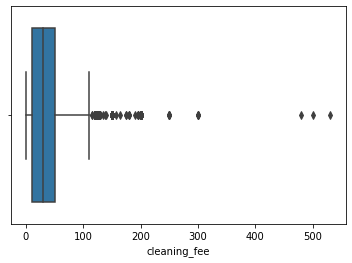

In [17]:
sb.boxplot(listings_df['cleaning_fee'])

In [18]:
# check values >100 usd. 
listings_df[listings_df['cleaning_fee']>100][['price', 'cleaning_fee', 'extra_people', 'minimum_nights']]

,price,cleaning_fee,extra_people,minimum_nights
92,400.0,120.0,0.0,2
101,168.0,120.0,20.0,5
198,350.0,150.0,0.0,7
215,700.0,130.0,50.0,7
319,350.0,200.0,0.0,7
...,...,...,...,...
19498,450.0,200.0,0.0,7
19500,450.0,200.0,0.0,7
19508,750.0,150.0,0.0,5
19510,500.0,150.0,0.0,5


It seems that high cleaning fee is applied to expensive accommodation, however few lines looks strange. Check lines that have high cleaning fee but cheaper night price.

In [19]:
listings_df.loc[(listings_df['cleaning_fee']>100) &(listings_df['cleaning_fee']>listings_df['price'])] \
    [['price', 'cleaning_fee', 'extra_people', 'guests_included']]

,price,cleaning_fee,extra_people,guests_included
1076,50.0,120.0,30.0,1
1619,110.0,250.0,0.0,1
2369,120.0,125.0,0.0,3
2881,118.0,480.0,0.0,1
2989,100.0,531.0,0.0,1
6243,99.0,150.0,10.0,1
6715,179.0,195.0,0.0,1
6890,240.0,250.0,0.0,1
10101,100.0,158.0,168.0,2
11275,117.0,130.0,65.0,4


In [20]:
listings_df.loc[(listings_df['cleaning_fee']>100) &(listings_df['cleaning_fee']>listings_df['price']), 'cleaning_fee']= \
    listings_df['price']

**extra_people**

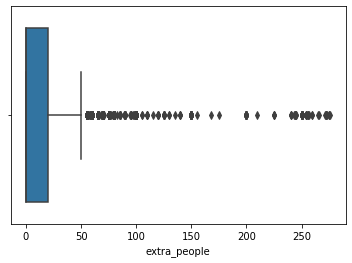

In [21]:
sb.boxplot(listings_df['extra_people'])

In [22]:
listings_df.loc[(listings_df['extra_people']>listings_df['price']), 'extra_people']=listings_df['price']

In [23]:
# check if there is still some unreasonable values in extra_people 
listings_df[(listings_df['extra_people']>100)&(listings_df['guests_included']<listings_df['accommodates'])] \
                                               [['price', 'cleaning_fee', 'extra_people', 
                                              'guests_included', 'accommodates']]

,price,cleaning_fee,extra_people,guests_included,accommodates
113,650.0,50.0,125.0,4,12
644,320.0,50.0,110.0,2,4
1213,600.0,500.0,250.0,2,4
1235,500.0,80.0,125.0,2,3
7537,395.0,60.0,250.0,3,4
7840,160.0,0.0,160.0,1,2
7970,299.0,65.0,225.0,4,6
8020,175.0,30.0,120.0,2,4
8388,275.0,120.0,110.0,2,5
8680,900.0,50.0,125.0,4,5


For me extra people for more than 100 usd still looks strange... but we will keep them.

Now, we've cleaned all colomns related to price, but since price depends on guests included, we need to calculate it per different groups of travellers (signle, couples, families, big group of friends).

In [24]:
# calculate price depending on number of people (max 16 people)
for num_travellers in range(1,listings_df['accommodates'].max()+1):
    col_name='price_for_'+str(num_travellers)
    listings_df[col_name]=(listings_df['price']+(num_travellers-listings_df['guests_included'])*listings_df['extra_people'])
    # if num of guests included is more than num of travellers than keep price for guests_included
    listings_df.loc[(listings_df['guests_included']>num_travellers),col_name]=listings_df['price']
    # if num of guests is more than num of poeple that can be accomodated than NaN
    listings_df.loc[(listings_df['accommodates']<num_travellers),col_name]=np.nan
    # add cleaning fees
    listings_df[col_name]=listings_df[col_name]+listings_df['cleaning_fee']

In [25]:
listings_df[[ 'price', 'cleaning_fee', 'guests_included','extra_people', 'minimum_nights', 'accommodates', 'price_for_1', 'price_for_2', 'price_for_3', 'price_for_4']].describe()

,price,cleaning_fee,guests_included,extra_people,minimum_nights,accommodates,price_for_1,price_for_2,price_for_3,price_for_4
count,19635.000000,19635.000000,19635.000000,19635.000000,19635.000000,19635.000000,19635.000000,19144.000000,8408.000000,6890.000000
mean,162.018589,32.477209,1.441915,11.025261,3.494169,2.860861,194.495798,198.618053,262.066484,287.330479
std,172.204181,26.926978,0.882541,21.650849,15.118688,1.293370,179.068399,179.227186,171.979629,181.248465
min,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,5.000000,5.000000,5.000000,5.000000
25%,99.000000,10.000000,1.000000,0.000000,2.000000,2.000000,124.000000,128.000000,180.000000,200.000000
50%,134.000000,30.000000,1.000000,0.000000,2.000000,2.000000,169.000000,170.000000,230.000000,250.000000
75%,189.000000,50.000000,2.000000,20.000000,3.000000,4.000000,225.000000,230.000000,300.000000,330.000000
max,9000.000000,500.000000,16.000000,276.000000,1001.000000,16.000000,9000.000000,9000.000000,8030.000000,8045.000000


## Exploratory analysis<a class="anchor" id="third-bullet"></a>

### Available accomodation options VS number of tenants

In [26]:
# counts how many 'accommodates' options of each type is present in dataframe
df1=listings_df['accommodates'].value_counts().reset_index(). \
    sort_values(by=['index'], ascending=True).reset_index(drop=True).rename(columns={'accommodates':'count', 
                                                                                     'index':'max_accommodates'})
# transform count to cumulative sum count (single traveller can book all present option, couple - accomodates >=2 )
for i in df1['max_accommodates'].tolist():
    df1.loc[df1['max_accommodates']==i, '# accomodation options']=df1[df1['max_accommodates']>=i]['count'].sum()

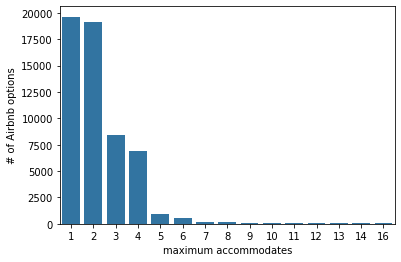

In [27]:
# plot number of options
sb.barplot(df1['max_accommodates'], df1['# accomodation options'], color=base_color); 
plt.xlabel('maximum accommodates');
plt.ylabel('# of Airbnb options');

If you travel with group of friends you have to be fast especially in high season, since number of available options is limited.

### Available accomodation options VS duration of your trip

In [28]:
# count how many options is present in each group of 'min_nights'
df1=listings_df['minimum_nights'].value_counts().reset_index(). \
    sort_values(by=['index'], ascending=True).reset_index(drop=True).rename(columns={'minimum_nights':'count', 
                                                                                     'index':'min_nights'})
# sumularive sum (person which plans 3 day drip can consider options with 1, 2 or 3 min_nights)
for i in df1['min_nights'].tolist():
    df1.loc[df1['min_nights']==i, '# accomodation options']=df1[df1['min_nights']<=i]['count'].sum()

Text(0, 0.5, '# of Airbnb options')

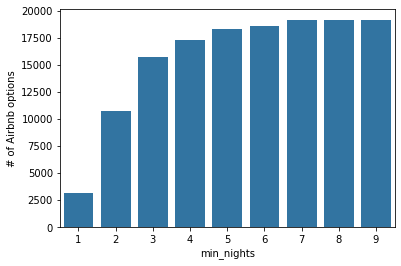

In [29]:
# plot number of options
sb.barplot(df1[df1['min_nights']<10]['min_nights'], df1['# accomodation options'], color=base_color); 
plt.ylabel('# of Airbnb options')

If you plan only one night stay, keep in mind that number of options is limited, and already can be taken by people that plan even longer trip

### Remove outliers

**Price**

By looking at the boxplot Prices vs Guests_included, we can see that prices higher than 2000 are unreasonable. Furthermore, I consider that people will not pay more than 1300 usd for single stay (it's olready on high side).  All prices higher than 1300 will be removed as outliers. 

However, it's a big question how pricing table was generated. Since, online check of some of this rediculously expensive appartments doesn't give such high prices

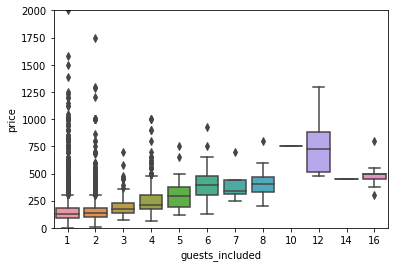

In [30]:
sb.boxplot(listings_df['guests_included'],listings_df['price'])
plt.xlabel('guests_included')
plt.ylabel('price')
plt.ylim(0,2000);

C:\Users\eks\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\eks\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


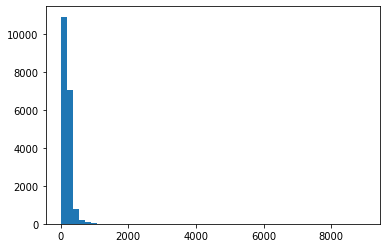

In [31]:
plt.hist(listings_df['price_for_2'], bins=50);

In [32]:
# drop outliers (>1300 usd per night for 2)
listings_df.drop(listings_df[listings_df['price']>1300].index, inplace=True)

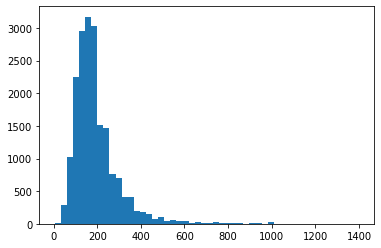

In [33]:
plt.hist(listings_df['price_for_2'], bins=50, alpha=1);

In [34]:
listings_df.shape

(19620, 102)

**Minimum_nights**

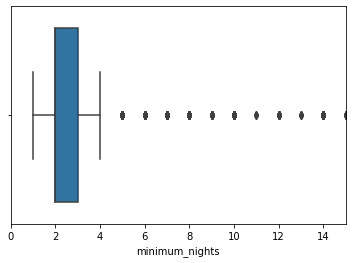

In [35]:
sb.boxplot(listings_df['minimum_nights'])
plt.xlim(0,15);

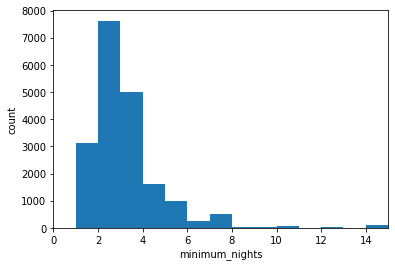

In [36]:
plt.hist(listings_df['minimum_nights'], bins=1000)
plt.xlim(0,15);
plt.xlabel('minimum_nights');
plt.ylabel('count');

In [37]:
listings_df[listings_df['minimum_nights']>4].shape

(2305, 102)

Dataframe contains 2305 entities with minimum_nights of stay more than 4. As most of tourists visits Amsterdam for weekend/long weekend, we will drop all rows with minimum_nights > 4. Other option you can assign 4 as minimum_nights for all accomodation with min_nights>4.

In [38]:
# drop rows with min dur of stay >3
listings_df.drop(listings_df[listings_df['minimum_nights']>4].index, inplace=True)
listings_df.shape

(17315, 102)

In [39]:
# keep original listings_df 
copy_listings_df=listings_df 

### Rearrange data for visualisation

For easy visualisations I want to regroup my dataframe 

listings_id | calc_price_for_1|  calc_price_for_2|...|  calc_price_for_16|minimum_nights
---|---|---|---|---|---
1|...|...|...|...|...
2|...|...|...|...|...

to the following format:

listings_id | number_of_people | Price | minimum_nights
---|---|---|---
1| 1| ... |...
1| 2| ... |...
1| 3| ... |...
1| ...| ... |...
1| 16| ... |...
2| 1| ... |...
2| 2| ... |...
...|...|...|...
2| 16| ... |...
...| ...| ... |...

In [40]:
# rearrange df shape
# make empty dataframe with 3 columns
new_df=pd.DataFrame(columns=['id', 'number_of_guests', 'price', 'minimum_nights'])
for i in listings_df.columns[listings_df.columns.str.startswith('price_for_')]:
    # select correct columns
    data1=listings_df[['id', i,'minimum_nights' ]]
    # add new col
    data1['number_of_guests']=i
    # rename columns
    data1.rename(columns={i:'price'}, inplace=True)
    # add this df at the bottom
    new_df=new_df.append(data1)

# drop all rows with NaN
new_df=new_df.dropna()

# extract number from column and transform to integer
new_df['number_of_guests']=new_df['number_of_guests'].str.extract('(\d+)')
new_df['number_of_guests']=new_df['number_of_guests'].astype(int)
new_df

C:\Users\eks\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\eks\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,id,number_of_guests,price,minimum_nights
0,2818,1,119.0,3
1,20168,1,100.0,1
3,27886,1,155.0,2
4,28871,1,75.0,2
5,29051,1,55.0,2
...,...,...,...,...
18093,39239986,16,1140.0,2
18290,39725240,16,1220.0,2
18861,40968524,16,590.0,2
19137,41781053,16,350.0,2


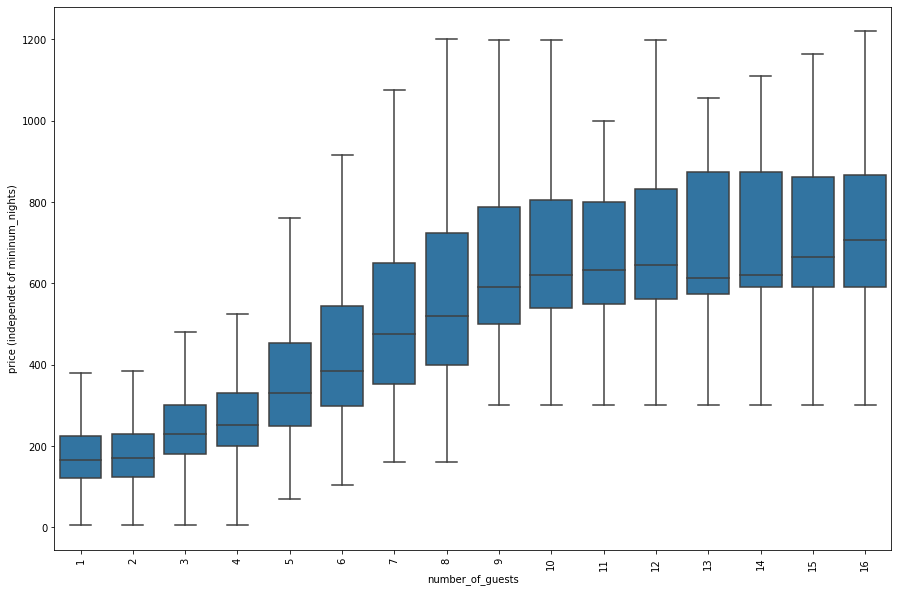

In [41]:
# plot price distribution by total number of people
plt.figure(figsize=[15, 10])
sb.boxplot(data = new_df, x = 'number_of_guests', y = 'price',  color=base_color, showfliers=False); 
plt.xticks(rotation=90);
plt.ylabel('price (independet of mininum_nights)');

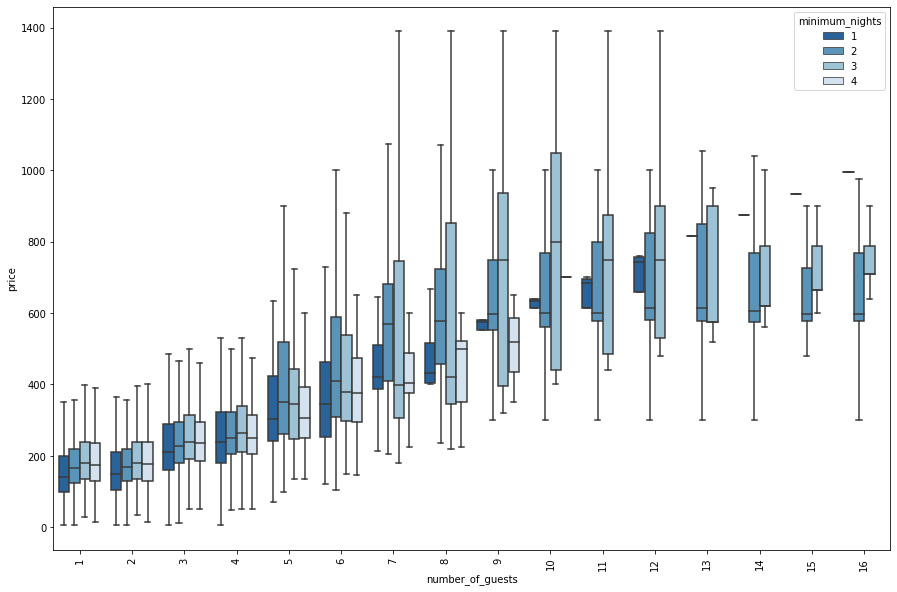

In [42]:
# plot price distribution by number of people and minimum  booking nights 
plt.figure(figsize=[15, 10])
sb.boxplot(data = new_df, x = 'number_of_guests', y = 'price', hue='minimum_nights', palette='Blues_r', showfliers=False); 
plt.xticks(rotation=90);

From this plot we can see that if you travel with small group of people the median value of the price is a bit lower for the listings with 1 minimum night of booking. Thus, keeping in mind that it's not so many options with 1 minimum night and price is a bit cheaper, it can be already taken by people that plans longer stay.

### Which neighbourhood to choose? 

We already saw that price distribution is skewed to the right, so it's beter to use median as charachteristics of the destribution.

In [43]:
# calculate average (median) price depending on neighborhood ('neghbourhood_cleansed')
neigh_grouped_df=listings_df[['neighbourhood_cleansed', 'price_for_2']]. \
                    groupby(['neighbourhood_cleansed']).agg(['median', 'mean'])
neigh_grouped_df[('price_for_2','diff')]=neigh_grouped_df[('price_for_2','mean')]- \
                    neigh_grouped_df[('price_for_2','median')]
neigh_grouped_df

price_for_2                       
                                            median        mean       diff
neighbourhood_cleansed                                                   
Bijlmer-Centrum                               99.5  117.224490  17.724490
Bijlmer-Oost                                  95.0  112.903614  17.903614
Bos en Lommer                                149.0  157.459432   8.459432
Buitenveldert - Zuidas                       160.0  177.621762  17.621762
Centrum-Oost                                 195.0  225.120332  30.120332
Centrum-West                                 195.0  231.497879  36.497879
De Aker - Nieuw Sloten                       135.0  174.131783  39.131783
De Baarsjes - Oud-West                       169.0  186.206537  17.206537
De Pijp - Rivierenbuurt                      180.0  199.652765  19.652765
Gaasperdam - Driemond                        100.0  116.572917  16.572917
Geuzenveld - Slotermeer                      138.0  162.149171  24.149171
IJburg - Zeeburgereiland                     185.0  200.323308  15.323308
Noord-Oost                                   159.0  168.774468   9.774468
Noord-West                                   150.0  164.294833  14.294833
Oostelijk Havengebied - Indische Buurt       150.0  172.167067  22.167067
Osdorp                                       115.0  135.237705  20.237705
Oud-Noord                                    169.0  204.422846  35.422846
Oud-Oost                                     170.0  180.639269  10.639269
Slotervaart                                  135.0  152.118457  17.118457
Watergraafsmeer                              160.0  184.925764  24.925764
Westerpark                                   165.0  187.352396  22.352396
Zuid                                         180.0  216.482082  36.482082

In [44]:
# order neighbourhoods from the most expensive to least
order_neig=listings_df[['neighbourhood_cleansed', 'price_for_2']].groupby(['neighbourhood_cleansed']).median(). \
    reset_index().sort_values(by=['price_for_2'], ascending=False)['neighbourhood_cleansed']

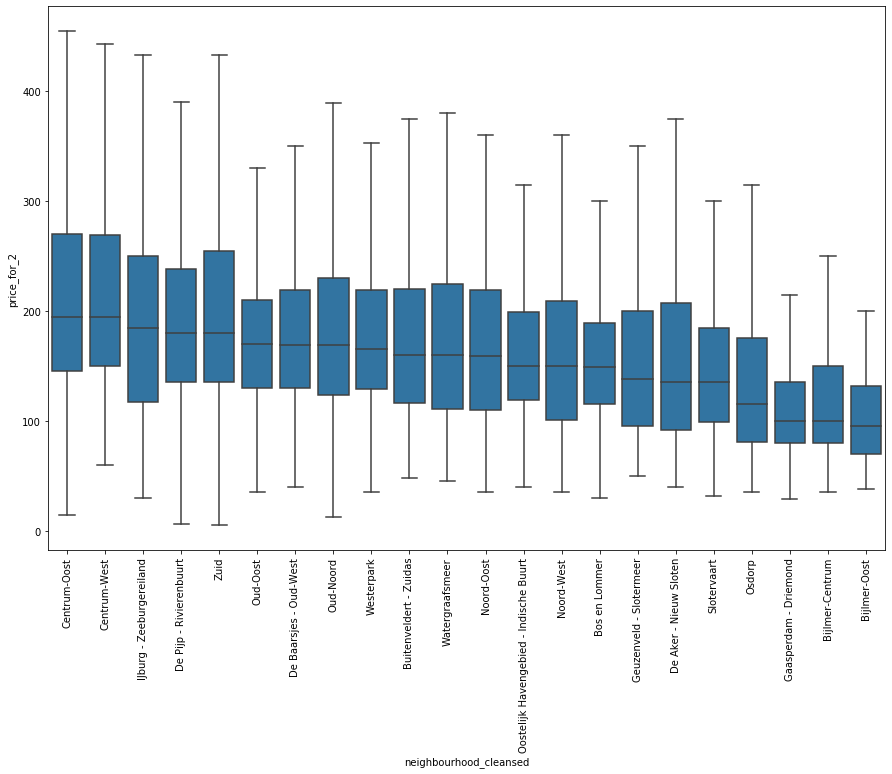

In [45]:
# plot 
plt.figure(figsize=[15, 10])
sb.boxplot(data = listings_df, x = 'neighbourhood_cleansed', y = 'price_for_2',  
           color=base_color, order=order_neig, showfliers=False); 
plt.xticks(rotation=90);

### Maps
For most of tourists the names of Amsterdam districts doesn't say to much, it's better to visualise data on a map.

In [46]:
# Creating a dataframe of Airbnb listing counts and median price per district
area_df = pd.DataFrame(listings_df.groupby('neighbourhood_cleansed').size())
area_df.rename(columns={0: 'number_of_listings'}, inplace=True)

area_df['median_price'] = listings_df.groupby('neighbourhood_cleansed')['price_for_2'].median().values
area_df['mean_price'] = listings_df.groupby('neighbourhood_cleansed')['price_for_2'].mean().values
area_df['mean_review_scores_rating'] = listings_df.groupby('neighbourhood_cleansed')['review_scores_rating'].mean().values
area_df['mean_review_scores_location'] = listings_df.groupby('neighbourhood_cleansed')['review_scores_location'].mean().values

area_df.reset_index()

# Join  dataframes
map_df = map_df.merge(area_df, left_on='neighbourhood', right_on='neighbourhood_cleansed')

In [47]:
#convert geometries into  EPSG=3857, as used in goodgle maps
map_df = map_df.to_crs(epsg=3857)

C:\Users\eks\AppData\Local\Continuum\anaconda3\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [48]:
# calculate center of each polygone
map_df['centroid'] = map_df.centroid

# create centroid df, with centroid as geometry 
centroid_df = gpd.GeoDataFrame(
    map_df[['neighbourhood','number_of_listings', 'median_price',
       'mean_price', 'mean_review_scores_rating',
       'mean_review_scores_location',  'centroid']],
    geometry='centroid')

In [49]:
# convert columns to int or floats with 2 digits 
centroid_df['median_price']=pd.to_numeric(centroid_df['median_price'], downcast='signed')
centroid_df['mean_price']=pd.to_numeric(round(centroid_df['mean_price']), downcast='signed')
centroid_df['mean_review_scores_rating']=pd.to_numeric(round(centroid_df['mean_review_scores_rating']), downcast='signed')
centroid_df['mean_review_scores_location']=pd.to_numeric(round(centroid_df['mean_review_scores_location'],2), downcast='signed')

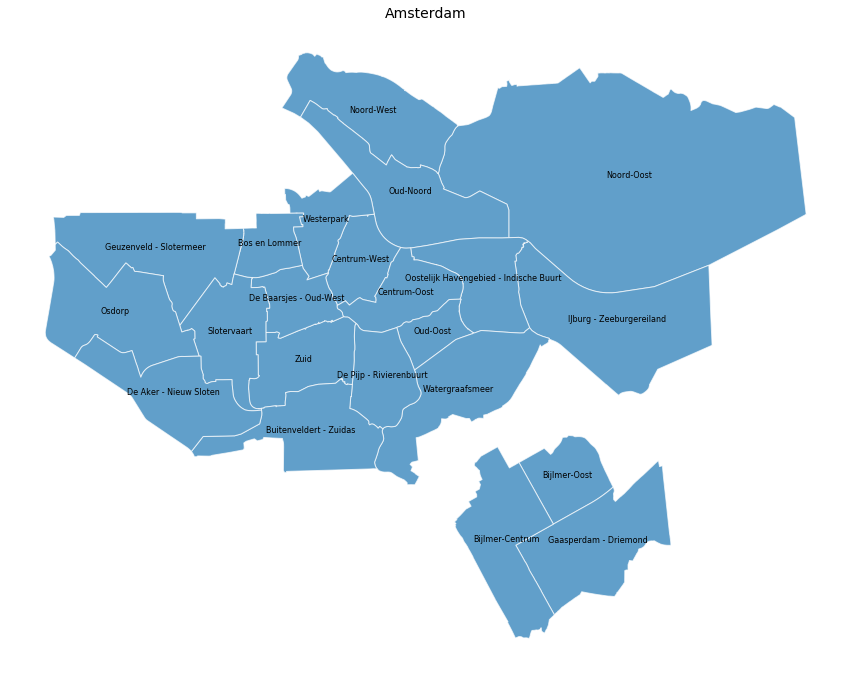

In [50]:
# Plotting each neighborhood 
fig1, ax1 = plt.subplots(1, figsize=(15, 15))

map_df.plot(ax=ax1, alpha=0.7, edgecolor='w')
ax1.axis('off')
ax1.set_title('Amsterdam', fontsize=14)

# add district names
for x, y, label in zip(centroid_df.geometry.x, centroid_df.geometry.y, centroid_df.neighbourhood):
    text=ax1.annotate(label, xy=(x, y), xytext=(0.1,0.1), horizontalalignment='center', textcoords="offset points")
    text.set_fontsize(8)

In [51]:
def plot_distr(data, data1, col_name, text):
    '''  
    function to plot statistics per district
    data - polygon data and statistics
    data1 - centroid data and statistics about each polygon, to print value on map
    col_name - statistic column
    text - grapoh header  
    ''' 

    fig1, ax1 = plt.subplots(1, figsize=(10, 10))
    data.plot(column=col_name, ax=ax1, cmap='Blues',  alpha=0.7, edgecolor='w')
    ax1.axis('off')
    ax1.set_title(text, fontsize=14)

    for x, y, label in zip(data1.geometry.x, data1.geometry.y, data1[col_name]):
        text=ax1.annotate(label, xy=(x, y), xytext=(0.1,0.1), horizontalalignment='center', textcoords="offset points")
        text.set_fontsize(8)

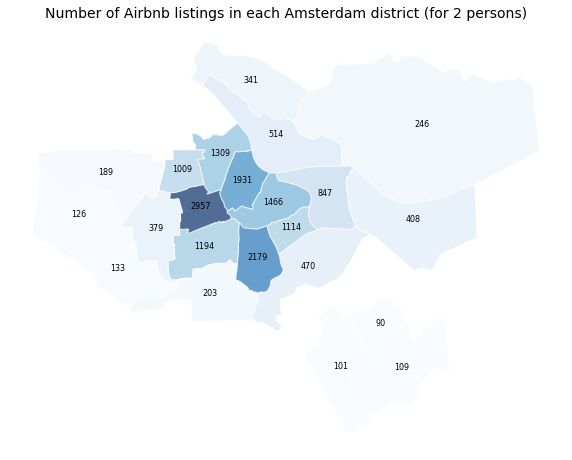

In [52]:
plot_distr(map_df, centroid_df, 'number_of_listings','Number of Airbnb listings in each Amsterdam district (for 2 persons)')

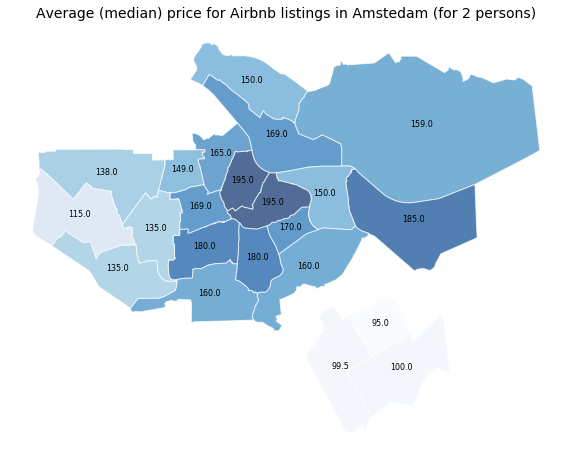

In [53]:
plot_distr(map_df, centroid_df, 'median_price', 'Average (median) price for Airbnb listings in Amstedam (for 2 persons)')

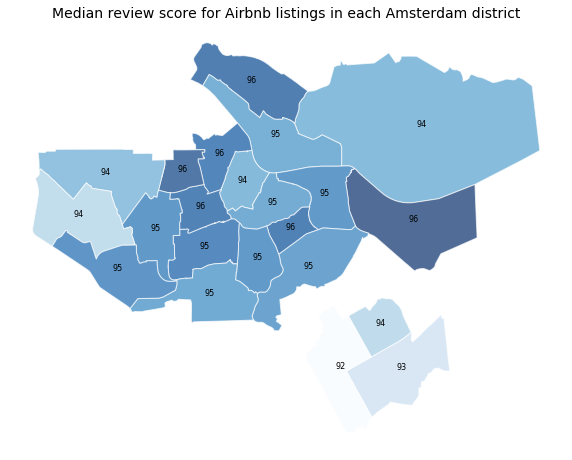

In [54]:
plot_distr(map_df, centroid_df, 'mean_review_scores_rating','Median review score for Airbnb listings in each Amsterdam district')

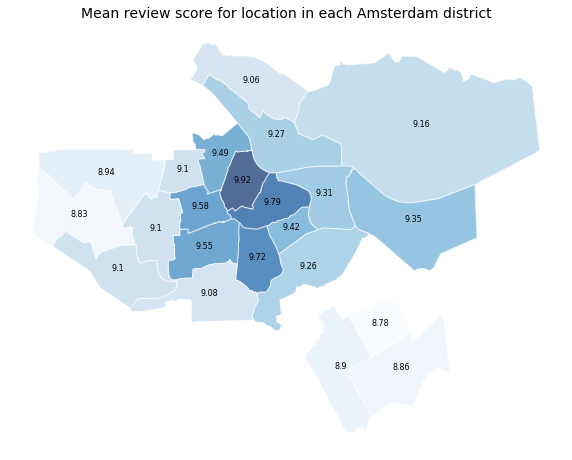

In [55]:
plot_distr(map_df, centroid_df,'mean_review_scores_location','Mean review score for location in each Amsterdam district')

## Price per season<a class="anchor" id="forth-bullet"></a>

In [66]:
def prepare_time_series(data, listings_df):
    '''
    Fuction joins calendar_df with listings columns:
    'price', 'accomodates' , 'guests_included' (in price), 
    'extra_guests','cleaning_fee', 'minimum_nights'
    
    calculates price per n people 
    
    '''
    
    data=data.merge(listings_df[['id', 'price', 'guests_included', 'extra_people',
                                   'minimum_nights', 'accommodates', 'cleaning_fee']], 
                       left_on='listing_id', how='inner', right_on='id', suffixes=('_cal', '_list'))
    
    # calculate price depends on number of people (max 4 people)
    for i in range(1,5):
        col_name='price_for_'+str(i)
        data[col_name]=(data['price_cal']+(i-data['guests_included'])*data['extra_people'])
        # if num of guests_included > num of travellers than use price from calendar
        data.loc[(data['guests_included']>i),col_name]=data['price_cal']
        # if number of guests_included < num of travellers then NaN
        data.loc[(data['accommodates']<i),col_name]=np.nan
        data[col_name]=data[col_name]+data['cleaning_fee']
        
    data.loc[data['available']=='t', 'av_price']=data['price_cal']
    data.loc[data['available']=='t', 'av_price_for_1']=data['price_for_1']
    data.loc[data['available']=='t', 'av_price_for_2']=data['price_for_2']    
    data.loc[data['available']=='t', 'av_price_for_3']=data['price_for_3']
    data.loc[data['available']=='t', 'av_price_for_4']=data['price_for_4']
        
    
    # group by date
    grouped_data=data.groupby(
       ['date']
        ).agg(
        {
            'available1': [sum, 'count'],
            'price_cal' :['median'],
            'price_for_1' :[ 'median'],
            'price_for_2' :[ 'median'],
            'price_for_3' :[ 'median'],
            'price_for_4' :[ 'median'],
            'av_price' :['median'],
            'av_price_for_1' :[ 'median'],
            'av_price_for_2' :[ 'median'],
            'av_price_for_3' :[ 'median'],
            'av_price_for_4' :[ 'median'],
            'minimum_nights_cal': [ 'mean']

        }
    )
    
    grouped_data['available_percent']=grouped_data[('available1','sum')]/grouped_data[( 'available1','count')]
    grouped_data.reset_index(inplace=True)
    return grouped_data

In [67]:
fgh=calendar_dfs['022020']


In [68]:
# loop through all calendars to prepare group by date
grouped_calendar_dfs={}
for i in cal_list:
    grouped_calendar_dfs[i]=prepare_time_series(calendar_dfs[i], listings_df)

In [69]:
grouped_calendar_dfs['032020'][('available_percent','')]

0      0.041509
1      0.076928
2      0.145019
3      0.171354
4      0.178169
         ...   
361    0.142593
362    0.142478
363    0.142478
364    0.142478
365    0.146712
Name: (available_percent, ), Length: 366, dtype: float64

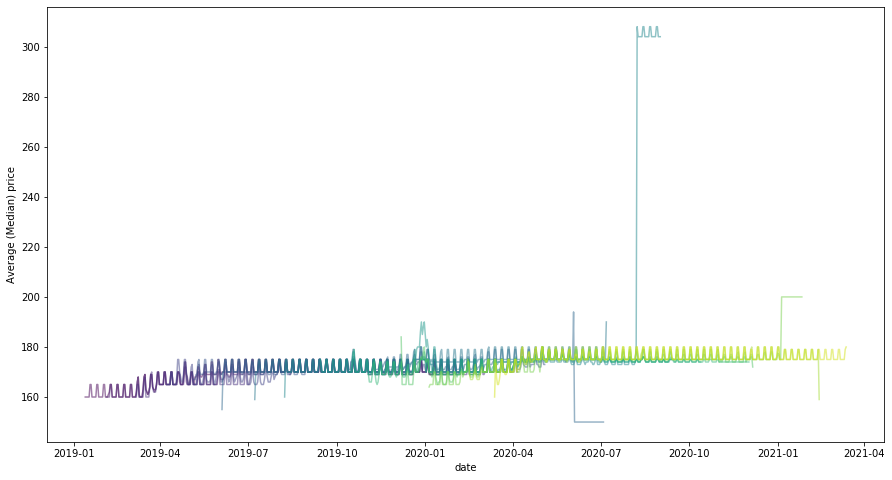

In [70]:
#plot for all grouped calendars average price per day
plt.figure(figsize=[15, 8])
c=0
for i in cal_list:
    plt.plot(grouped_calendar_dfs[i]['date'], grouped_calendar_dfs[i][('price_for_2', 'median')],
             color=viridis.colors[c], alpha=0.5 )
    c=c+1
plt.xlabel('date'); 
plt.ylabel('Average (Median) price'); 

Graph presents 15 overlaping plots, since each caslendar contains data for full coming year. The prices are not fixed (if not booked), so owner of appartment can adjust price during the year. I assume that the most representative from each calendar is only fiest month. Let's plot if 

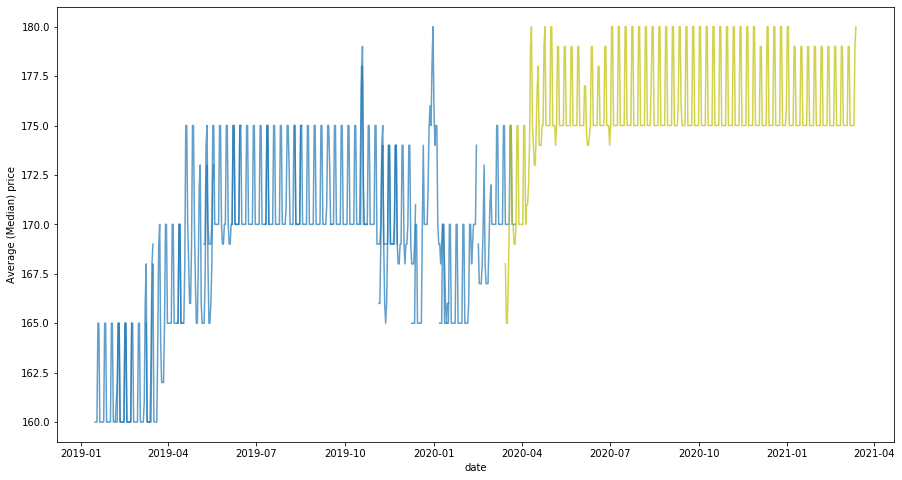

In [71]:
plt.figure(figsize=[15, 8])
c=0
for i in cal_list[0:len(cal_list)-1]:
    plt.plot(grouped_calendar_dfs[i]['date'].loc[2:40,], 
             grouped_calendar_dfs[i][('price_for_2', 'median')].loc[2:40,],color=base_color, alpha=0.7)
    c=c+1

plt.plot(grouped_calendar_dfs[cal_list[len(cal_list)-1]]['date'].loc[2:], 
         grouped_calendar_dfs[cal_list[len(cal_list)-1]][('price_for_2', 'median')].loc[2:],color='y', alpha=0.7)
plt.xlabel('date'); 
plt.ylabel('Average (Median) price'); 


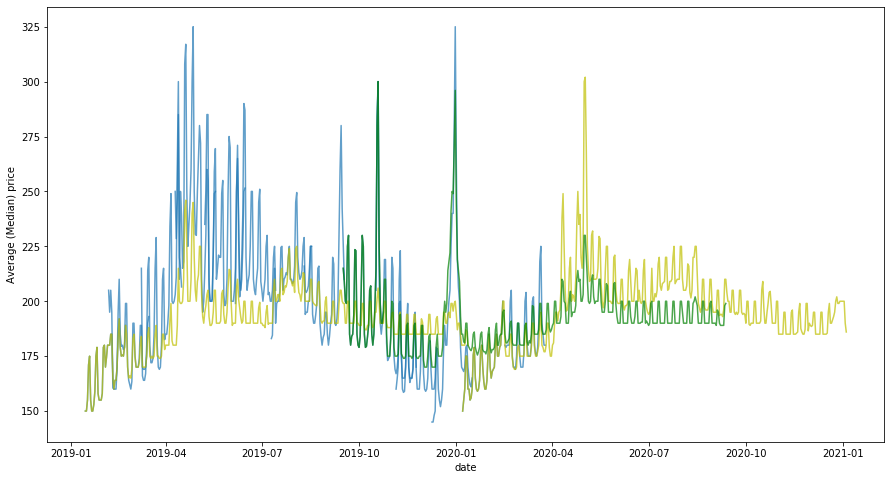

In [80]:
plt.figure(figsize=[15, 8])
c=0
for i in cal_list[0:len(cal_list)-1]:
    plt.plot(grouped_calendar_dfs[i]['date'].loc[2:40,], 
             grouped_calendar_dfs[i][('av_price_for_1', 'median')].loc[2:40,],color=base_color, alpha=0.7)
    c=c+1

plt.plot(grouped_calendar_dfs['012020']['date'].loc[2:], 
         grouped_calendar_dfs['012020'][('av_price_for_1', 'median')].loc[2:],color='y', alpha=0.7)
plt.xlabel('date'); 
plt.ylabel('Average (Median) price'); 
plt.plot(grouped_calendar_dfs['012019']['date'].loc[2:], 
         grouped_calendar_dfs['012019'][('av_price_for_1', 'median')].loc[2:],color='y', alpha=0.7 );
plt.ylabel('Average (Median) price'); 
plt.plot(grouped_calendar_dfs['092019']['date'].loc[2:], 
         grouped_calendar_dfs['092019'][('av_price_for_1', 'median')].loc[2:],color='g', alpha=0.7 );

Blue graph is build from each first month prediction, yellow one is prediction for the full year. 

We see few clear peaks: 
- clear seasonality: high season (april-beggining of october)
- end of april (27.04): King's day
- end of october (19.10): Amsterdam marathon (not very clear peak, but prices already started to go down)
- 31.12: New year

Let's add prices estimated in March 2019 (in yellow). We can see that expected average price changed if we compare it with one month in advance extimation. However, it doesn't always meen that planning you trip much more is advance will keep your money. If you plan to visit Amsterdam in high season, better to take care of accommodation in advance, on th eother side if you travelling in November - December (except New year), you might want to pospone your booking till last moment. However, we are talking about 2.5 usd savings on average price :)))

Since data scraped only one a month, it doesn't give good overview on what happend with prices if you book at the last moment. 


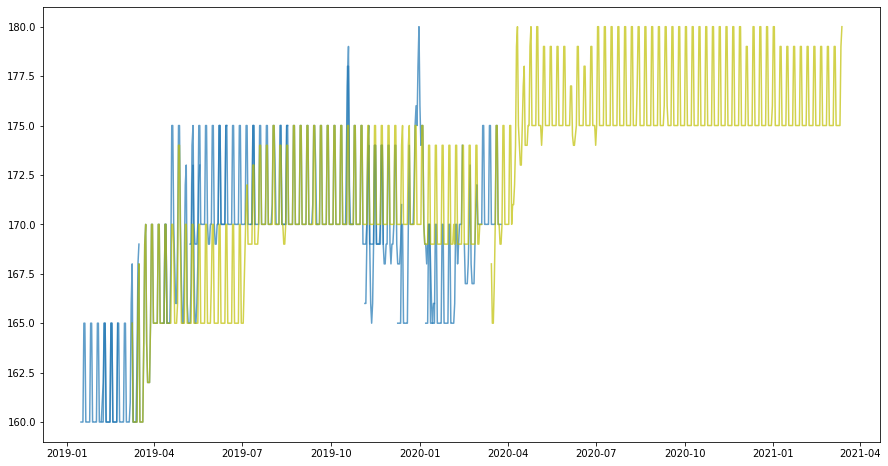

In [72]:
plt.figure(figsize=[15, 8])
c=0
for i in cal_list[0:len(cal_list)-1]:
    plt.plot(grouped_calendar_dfs[i]['date'].loc[2:40,], 
             grouped_calendar_dfs[i][('price_for_2', 'median')].loc[2:40,],color=base_color, alpha=0.7)#viridis.colors[c] )
    c=c+1
    

plt.plot(grouped_calendar_dfs[cal_list[len(cal_list)-1]]['date'].loc[2:], 
         grouped_calendar_dfs[cal_list[len(cal_list)-1]][('price_for_2', 'median')].loc[2:],color='y', alpha=0.7)#viridis.colors[c]);
plt.plot(grouped_calendar_dfs['032019']['date'].loc[2:], 
         grouped_calendar_dfs['032019'][('price_for_2', 'median')].loc[2:],color='y', alpha=0.7 );

In [73]:
print ('file_name', 'min', 'meidan', 'max')
for i in cal_list[0:len(cal_list)-1]:
    print (i, "%.2f" %grouped_calendar_dfs[i][('available_percent','')].min(),
           "%.2f" %grouped_calendar_dfs[i][('available_percent','')].median(), 
          "%.2f" %grouped_calendar_dfs[i][('available_percent','')].max())

file_name min meidan max
012019 0.08 0.13 0.19
022019 0.03 0.12 0.16
032019 0.03 0.12 0.15
042019 0.01 0.12 0.15
052019 0.03 0.13 0.16
062019 0.00 0.14 0.33
072019 0.01 0.14 0.31
082019 0.00 0.13 0.23
092019 0.01 0.13 0.18
102019 0.02 0.12 0.20
112019 0.00 0.12 0.20
122019 0.01 0.12 0.20
012020 0.00 0.12 0.21
022020 0.04 0.12 0.24


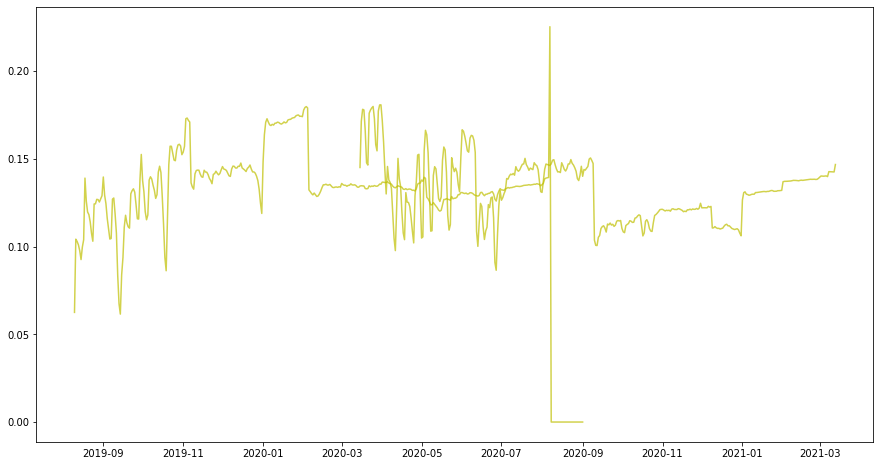

In [74]:
plt.figure(figsize=[15, 8])
c=0
for i in cal_list[0:len(cal_list)-1]:
    #plt.plot(grouped_calendar_dfs[i]['date'].loc[2:40,], 
     #       grouped_calendar_dfs[i][('available_percent','')].loc[2:40,],color='grey', alpha=0.7)#viridis.colors[c] )
    c=c+1
    

plt.plot(grouped_calendar_dfs[cal_list[len(cal_list)-1]]['date'].loc[2:], 
         grouped_calendar_dfs[cal_list[len(cal_list)-1]][('available_percent','')].loc[2:],color='y', alpha=0.7)#viridis.colors[c]);
plt.plot(grouped_calendar_dfs['082019']['date'].loc[2:], 
         grouped_calendar_dfs['082019'][('available_percent','')].loc[2:],color='y', alpha=0.7 );

## Predicting prices based on listings features<a class="anchor" id="fifth-bullet"></a>

We will use only numeric or categorical columns for now and drop all long text columns

numeric_cols=[   'host_listings_count',
             'host_total_listings_count', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 
             'guests_included', 'minimum_nights', 'number_of_reviews' , 'number_of_reviews_ltm',
            'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 
                           'review_scores_communication', 'review_scores_location', 'review_scores_value', 
                             'calculated_host_listings_count', 
                           'reviews_per_month', 'price1']
categorical_cols=[ 'host_has_profile_pic','host_is_superhost','neighbourhood', 'property_type', 'room_type', 'bed_type',  
                    'cancellation_policy','instant_bookable','is_business_travel_ready', ]

In [ ]:
# choose subset of interesting columns
numeric_cols=[ 'accommodates', 'bathrooms', 'bedrooms', 'beds', 
             'guests_included', 'minimum_nights','number_of_reviews' ,
            'review_scores_rating', 'review_scores_cleanliness', 'review_scores_location', 'review_scores_value', 
            'calculated_host_listings_count', 'reviews_per_month', 'price']
categorical_cols=[ 'neighbourhood_cleansed', 'room_type' ]

# df for modelling
data=listings_df[categorical_cols +numeric_cols]

In [ ]:
data.dropna(inplace=True)

In [ ]:
# check how columns correlates
corr=data.corr()
plt.figure(figsize=[15, 10])
ax = sb.heatmap(
    corr, annot=True, fmt='.2f', 
    square=True
)


Price mostly correlates to 'accomodates', 'bathroom', 'bedrooms', 'beds', 'guests_included' and almost no correlation see with review scores

In [ ]:
def lin_reg_prediction(X, y):
    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X_train, y_train) #Fit
        
    #Predict and score the model
    y_train_pred=lm_model.predict(X_train)
    y_test_pred = lm_model.predict(X_test) 

    train_score=r2_score(y_train, y_train_pred)
    test_score=r2_score(y_test, y_test_pred)
    
    plt.plot(y_train, y_train_pred, '.')
    plt.plot(y_test, y_test_pred, '.')

    print (train_score, test_score)
    return (train_score, test_score)

### Linear regression on numeric columns

In [ ]:
# features df
X=data[numeric_cols].drop('price', axis=1)
# prediction column
y=data['price']

In [ ]:
X.dtypes

Prediction on numeric columns only

In [ ]:
train_score, test_score=lin_reg_prediction(X, y)

### Linear regression on numeric and categorical columns

In [ ]:
# Get dummies of categorical columns
dummy_cols_df = pd.get_dummies(data[categorical_cols],prefix=categorical_cols, prefix_sep='_',
                               drop_first=True, dummy_na=False)

# X =numeric cols+categorical cols
X=pd.concat([X, dummy_cols_df], axis=1)

In [ ]:
print (X.shape)
X.head()

In [ ]:
train_score, test_score=lin_reg_prediction(X, y, test_size=0.3, random_state=42)

We can see that by adding few categorical columns we improved r2 score. 

### XGBoost Regression

In [ ]:
#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
train_pred = xgb_reg.predict(X_train)
test_pred = xgb_reg.predict(X_test)

train_score=r2_score(y_train, train_pred)
test_score=r2_score(y_test, test_pred)
print (train_score, test_score)

In [ ]:
plt.plot(train_pred, y_train, '.')
plt.plot(test_pred, y_test, '.');

Some extra improvemet, however the models doesn't perform great. To improve prediactions we can include extra features (for example extracted from text variables) or try different prediction models and their parameters. 

## Conclusions<a class="anchor" id="sixth-bullet"></a>

- If you plan only one night stay, better to book in advance, since amount of appartments for you search will be limited and priced on that type of appartment is a bit cheaper, thus it can be already booked.
- If you want a bit cheaper accomodation, go outside of city center, there is a lot of nice recidential areas in amsterdam.
- There is clear seasonality. High season is from April to beginning of October. The most expensive dates are New Year eve, Kind's day and Amsterdam marathon. 
- Smart selection of additional features can improve predictions of prices.
- To improve prediction try different regression models.